In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluate IoU for CNN

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [2]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}/images"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

In [3]:
df_bbox = pd.read_csv(file_path_bbox)
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = '/cluster/home/taheeraa/datasets/chestxray-14/images/' + merged_df['Image Index']
df = merged_df
df.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,13118,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,14716,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,29817,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,14687,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,17877,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


# Inference with gradcam
Funker bra på dette: 00010828_039
00021703_001, 00005066_030, 00027441_002

In [112]:
img_id = "00021703_001"
img_index = f"{img_id}.png"
df_filtered = merged_df[merged_df['Image Index'] == img_index]
col_img_index_df = df[df['Image Index'] == img_index]
img_path = col_img_index_df['filepath'].values[0]
print(img_path)
df_filtered

/cluster/home/taheeraa/datasets/chestxray-14/images/00021703_001.png


,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
315,00021703_001.png,Effusion,563.768889,511.184601,208.213333,155.875556,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
469,00021703_001.png,Infiltrate,113.208889,659.095712,158.151111,55.751111,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
973,00021703_001.png,Atelectasis,136.362674,500.811858,616.675556,212.764444,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


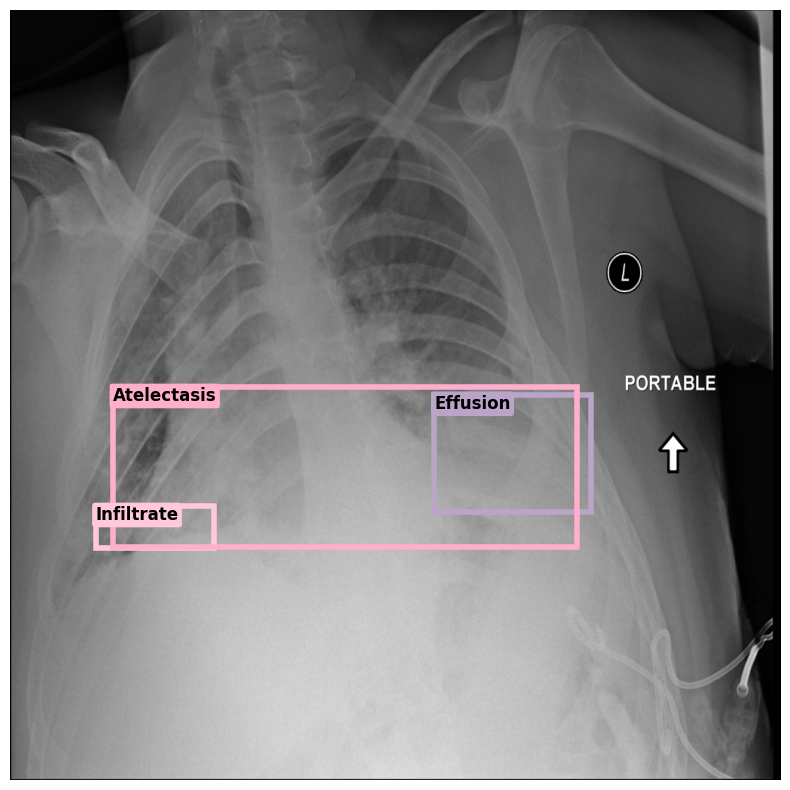

In [113]:


# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = col_img_index_df['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(
    colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(col_img_index_df['filepath'].values[0])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in col_img_index_df.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4,
                                edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold',
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.axis('off')
plt.show()


## loading model

In [114]:
base = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/05-change-classifier-head/"
pretrained_weights = base + "densenet121_imagenet_1k_adamw_32_bce_aug_class/model.pth.tar"

experiment_name = os.path.basename(os.path.dirname(pretrained_weights))
model_str = experiment_name.split('_')[0]
print(experiment_name, model_str)

def classifying_head(in_features: int, num_labels: int):
    return nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=in_features, out_features=128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=128),
        nn.Linear(128, num_labels),
    )

model = timm.create_model('densenet121', num_classes=num_labels, pretrained=True)
model.classifier = classifying_head(1024, num_labels)
    
checkpoint = torch.load(pretrained_weights, map_location="cpu")
print(checkpoint.keys())
state_dict = checkpoint['state_dict']
msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

densenet121_imagenet_1k_adamw_32_bce_aug_class densenet121
dict_keys(['epoch', 'lossMIN', 'state_dict', 'optimizer', 'scheduler'])
Loaded with msg: <All keys matched successfully>


## prepare data

In [115]:
def load_and_preprocess_images(image_path,normalize="imagenet"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    img_tensor = transform(Image.open(image_path).convert('RGB')).unsqueeze(0)  # Add a batch dimension
    #batch = torch.stack(images)  # Stack images into a single batch
    return img_tensor

input_tensor = load_and_preprocess_images(img_path)
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [116]:
rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

## looking at xai

In [117]:
methods = {
    "gradcam": GradCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "fullgrad": FullGrad
}

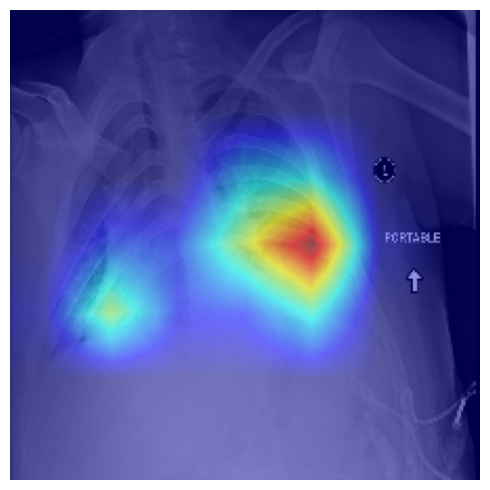

In [118]:
target_layers = [model.features.norm5]

cam = methods["gradcam"](model=model, target_layers=target_layers)

cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,
                    eigen_smooth=True,
                    aug_smooth=False)

grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figsize if needed for better display

ax.imshow(cam_image)
ax.axis('off')

plt.tight_layout()
plt.show()

# create bbox

In [119]:
def scale_bboxes(bboxes, orig_size=(1024, 1024), cam_size=(224, 224)):
    """
    Scales bounding boxes from Grad-CAM resolution back to original image size.

    Parameters:
    - bboxes: List of bounding boxes in the format [x, y, w, h].
    - orig_size: Tuple (width, height) of the original image size.
    - cam_size: Tuple (width, height) of the CAM image size.

    Returns:
    - scaled_bboxes: List of scaled bounding boxes in the format [x, y, w, h].
    """
    # Calculate scale factors for width and height
    scale_x = orig_size[0] / cam_size[0]
    scale_y = orig_size[1] / cam_size[1]

    # Scale each bounding box
    scaled_bboxes = []
    for x, y, w, h in bboxes:
        scaled_x = int(x * scale_x)
        scaled_y = int(y * scale_y)
        scaled_w = int(w * scale_x)
        scaled_h = int(h * scale_y)
        scaled_bboxes.append([scaled_x, scaled_y, scaled_w, scaled_h])

    return scaled_bboxes

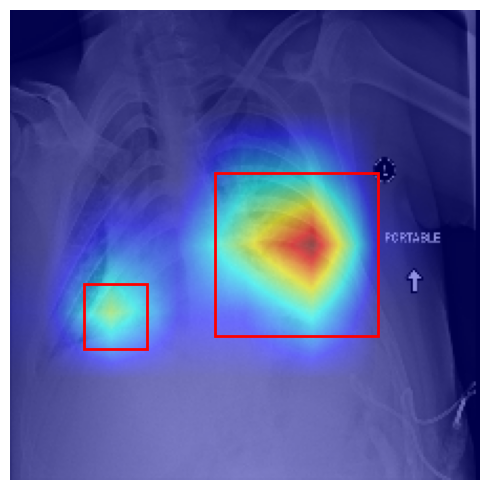

In [120]:
# Extract the red channel
red_channel = cam_image[:, :, 0]

# Threshold the red channel
thresh = cv2.threshold(red_channel, np.max(red_channel) * 0.7, 255, cv2.THRESH_BINARY)[1]

# Apply morphological operations
kernel = np.ones((10, 10), np.uint8)  # larger kernel
dilation = cv2.dilate(thresh, kernel, iterations=3)

# Find contours
contours, _ = cv2.findContours(dilation.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours and calculate bounding boxes
contours = [c for c in contours if cv2.contourArea(c) > 100]  # higher area threshold
bounding_boxes = [cv2.boundingRect(c) for c in contours]
bounding_boxes.sort(key=lambda x: x[2] * x[3], reverse=True)
bounding_boxes = bounding_boxes[:4]

# Display the results
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cam_image)
for bbox in bounding_boxes:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
ax.axis('off')
plt.tight_layout()
plt.show()

In [121]:
# Scale the bounding boxes to the original image size
scaled_bboxes = scale_bboxes(bounding_boxes)
scaled_bboxes

[[443, 352, 356, 356], [160, 594, 137, 141]]

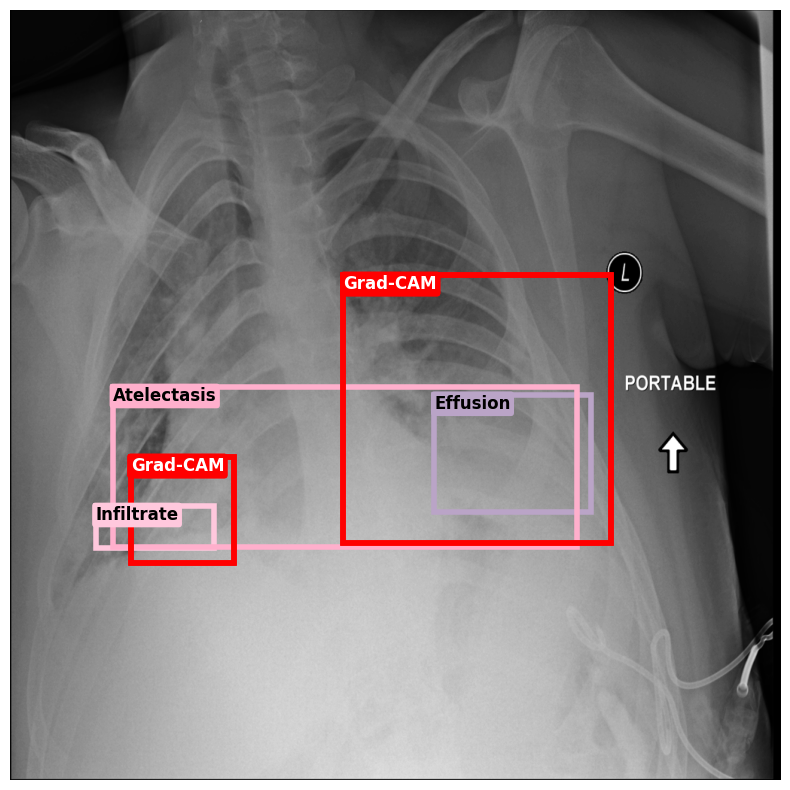

In [122]:
# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = col_img_index_df['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(figsize=(20, 10))

# Show the image
ax.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in col_img_index_df.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold',
            bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

# Additional bounding box from scaled Grad-CAM, color it red
for bbox in scaled_bboxes:
    x, y, w, h = bbox
    rect_gradcam = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor='red', facecolor='none')
    ax.add_patch(rect_gradcam)
    ax.text(x, y, 'Grad-CAM', verticalalignment='top', color='white', fontsize=12, weight='bold',
            bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

    ax.add_patch(rect_gradcam)
    ax.text(bbox[0], bbox[1], 'Grad-CAM', verticalalignment='top', color='white', fontsize=12, weight='bold',
            bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

ax.axis('off')
plt.show()
